In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image, ImageFile
import tensorflow as tf
import json
import glob
import random

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import gradio as gr
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [6]:
import pathlib
dataset_path = "./dataset(2)/"
train_data_dir = pathlib.Path(dataset_path+"/train")
test_data_dir = pathlib.Path(dataset_path+"/test")

train_files = glob.glob(r""+dataset_path+"/train/*.png")
train_files = random.sample(train_files, 1000)
train_datasize = len(train_files)
print("training data:", len(train_files))

test_files = glob.glob(r""+dataset_path+"/test/*.png")
test_files = random.sample(test_files, 500)
test_datasize = len(test_files)
print("test data:", len(test_files))

training data: 1000
test data: 500


In [8]:
images = list(train_data_dir.glob('*'))
random_image = random.choice(images)
im = PIL.Image.open(str(random_image))

width, height = im.size
print(width)
print(height)
im.resize((300, 300)).show()

1024
1024


In [14]:
img_height = 1024
img_width = 1024
class_names = np.array(sorted(['volcano', 'flooding', 'fire', 'tsunami']))
print(class_names)

['fire' 'flooding' 'tsunami' 'volcano']


In [15]:
def get_label(file_path, type):
    parts = file_path.split(os.path.sep)
    print(len(parts))
    print(parts)
    print(parts[1])
    path = './labels/'
    if type == "test":
        path = './labels/'
    f = open(path + parts[1].split('.')[0] +'.json')
    data = json.load(f)
    disaster_type = data['metadata']['disaster_type'] 
    f.close()

    label = disaster_type == class_names
    one_hot = np.zeros(len(class_names), dtype=np.uint8)
    one_hot[label] = 1

    return one_hot


def get_label_from_one_hot(array):
    return class_names[np.where(array == 1)]

In [16]:
train_X = np.zeros((train_datasize, img_height, img_width, 3), dtype=np.uint8)
train_Y = np.zeros((train_datasize, len(class_names)), dtype=np.uint8)

for i in range(len(train_files)):
    img= PIL.Image.open(train_files[i])
    train_X[i] = np.array(img)
    train_Y[i] = get_label(train_files[i], "train")
print("train")
print(train_X.shape)
print(train_Y.shape)

test_X = np.zeros((test_datasize, img_height, img_width, 3), dtype=np.uint8)
test_Y = np.zeros((test_datasize, len(class_names)), dtype=np.uint8)

for i in range(len(test_files)):
    img= PIL.Image.open(test_files[i])
    test_X[i] = np.array(img)
    test_Y[i] = get_label(test_files[i], "test")
print("test")
print(test_X.shape)
print(test_Y.shape)

2
['./dataset(2)//train', 'portugal-wildfire_00001747_post_disaster.png']
portugal-wildfire_00001747_post_disaster.png
2
['./dataset(2)//train', 'portugal-wildfire_00001154_pre_disaster.png']
portugal-wildfire_00001154_pre_disaster.png
2
['./dataset(2)//train', 'portugal-wildfire_00001042_post_disaster.png']
portugal-wildfire_00001042_post_disaster.png
2
['./dataset(2)//train', 'nepal-flooding_00000177_post_disaster.png']
nepal-flooding_00000177_post_disaster.png
2
['./dataset(2)//train', 'tuscaloosa-tornado_00000109_pre_disaster.png']
tuscaloosa-tornado_00000109_pre_disaster.png
2
['./dataset(2)//train', 'portugal-wildfire_00000351_post_disaster.png']
portugal-wildfire_00000351_post_disaster.png
2
['./dataset(2)//train', 'nepal-flooding_00000591_pre_disaster.png']
nepal-flooding_00000591_pre_disaster.png
2
['./dataset(2)//train', 'nepal-flooding_00000377_pre_disaster.png']
nepal-flooding_00000377_pre_disaster.png
2
['./dataset(2)//train', 'moore-tornado_00000081_pre_disaster.png']
moo

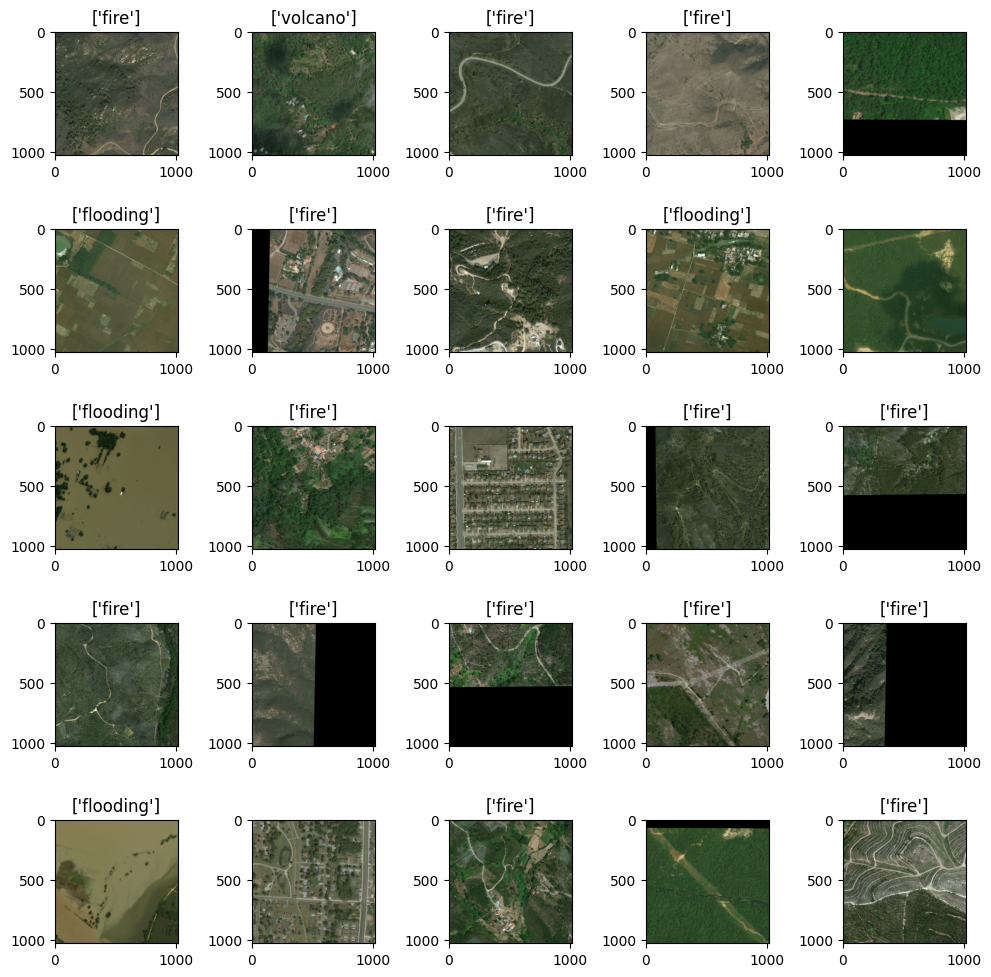

In [17]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)    
    choice = random.randint(0, train_datasize-1)
    plt.title(get_label_from_one_hot(train_Y[choice]))
    plt.imshow(train_X[choice])

plt.tight_layout()
plt.show()

In [24]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation="softmax"),
])

In [25]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 1024, 1024, 3)     0         
                                                                 
 conv2d (Conv2D)             (None, 1024, 1024, 16)    448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 512, 512, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 256, 256, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 64)      1

In [26]:
epochs = 7
batch_size = 5
history = model.fit(
  train_X,
  train_Y,
  validation_data=(test_X, test_Y),
  epochs=epochs,
  batch_size=batch_size
)

Epoch 1/7
200/200 [==============================] - 666s 3s/step - loss: 1.1545 - accuracy: 0.7290 - val_loss: 0.9719 - val_accuracy: 0.7060
Epoch 2/7
200/200 [==============================] - 1243s 6s/step - loss: 0.9446 - accuracy: 0.7370 - val_loss: 0.8817 - val_accuracy: 0.7040
Epoch 3/7
200/200 [==============================] - 868s 4s/step - loss: 0.7745 - accuracy: 0.7600 - val_loss: 1.3080 - val_accuracy: 0.5580
Epoch 4/7
200/200 [==============================] - 599s 3s/step - loss: 0.4443 - accuracy: 0.8630 - val_loss: 1.4635 - val_accuracy: 0.7140
Epoch 5/7
200/200 [==============================] - 668s 3s/step - loss: 0.2117 - accuracy: 0.9430 - val_loss: 2.5200 - val_accuracy: 0.7140
Epoch 6/7
200/200 [==============================] - 653s 3s/step - loss: 0.5144 - accuracy: 0.8760 - val_loss: 1.5852 - val_accuracy: 0.7120
Epoch 7/7
200/200 [==============================] - 670s 3s/step - loss: 0.1585 - accuracy: 0.9500 - val_loss: 3.6190 - val_accuracy: 0.7080


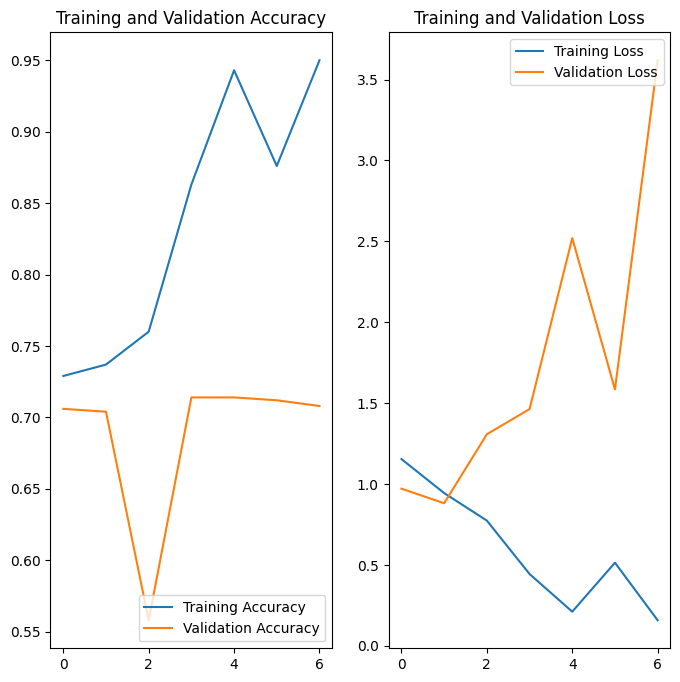

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
model.save("disaster-classification-model")

INFO:tensorflow:Assets written to: disaster-classification-model\assets


INFO:tensorflow:Assets written to: disaster-classification-model\assets


In [29]:
tf.keras.models.save_model(model,'model2.hdf5')

In [30]:
def disaster_classification(img):
    print(img.shape)
    image = np.zeros((1, 1024, 1024, 3), dtype=np.uint8)
    image[0] = img
    prediction = model.predict(image).tolist()[0]
    print(prediction)
    return {class_names[i]: prediction[i] for i in range(len(class_names))}

iface = gr.Interface(
    fn = disaster_classification,
    inputs = gr.inputs.Image(shape=(1024, 1024), image_mode='RGB', invert_colors=False, source="upload", type='numpy'), 
    outputs = gr.outputs.Label(),
    allow_screenshot=False, 
    allow_flagging='never'
)
iface.launch(share=True, show_error=True, inline=True, debug=True)

c:\Users\harsh\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
c:\Users\harsh\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
c:\Users\harsh\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
c:\Users\harsh\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)
c:\Users\harsh\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\de

Running on local URL:  http://127.0.0.1:7860

Could not create share link, please check your internet connection.


(1024, 1024, 3)
1/1 [==============================] - 0s 277ms/step
[0.0, 1.0, 1.556046624475912e-26, 2.8436979080442076e-22, 7.634228313110252e-31, 7.76613717778929e-10]
(1024, 1024, 3)
1/1 [==============================] - 0s 409ms/step
[0.0, 0.9975641965866089, 7.330955753559465e-08, 4.114300224955514e-07, 8.925307541651772e-12, 0.002435284201055765]
(1024, 1024, 3)
1/1 [==============================] - 0s 339ms/step
[1.5938034287007547e-34, 0.9946962594985962, 9.46560305692401e-07, 1.8428298886874472e-09, 4.628742267948072e-12, 0.005302744451910257]
(1024, 1024, 3)
1/1 [==============================] - 0s 146ms/step
[7.090139320098388e-07, 0.5472089648246765, 0.1057550311088562, 0.005960074719041586, 0.2767656445503235, 0.06430961191654205]
(1024, 1024, 3)
1/1 [==============================] - 0s 157ms/step
[1.8368962048538977e-19, 0.9997534155845642, 6.054218033568759e-07, 1.0248662363210315e-08, 1.8337586027428188e-07, 0.0002458266098983586]
(1024, 1024, 3)
1/1 [============